<a href="https://colab.research.google.com/github/angelrecalde2024/Power-System-Planning-and-Transmission-Design-2026/blob/main/LoadCurveAndLCD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Total energy (MWh): 306.0
Average load (MW): 12.75
Peak load (MW): 18.0
Load factor (%): 70.83333333333334
Total hours: 24.0


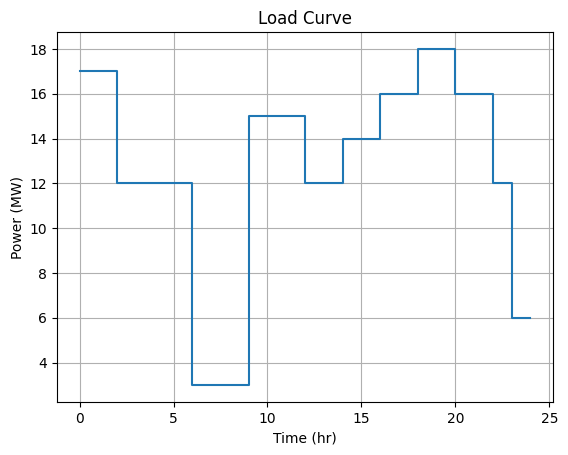

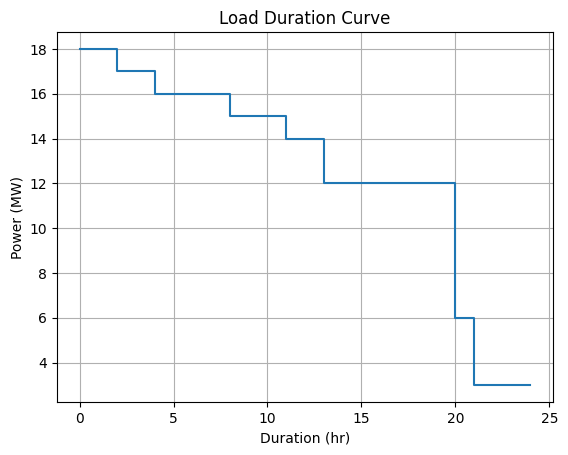

In [1]:
# notebook_cell: load_curve_ldc.py (Colab-ready)
"""
Load Curve + Load Duration Curve (LDC)
Input format: array-like with columns [t_start_hr, t_end_hr, power_MW]
"""

from __future__ import annotations

from dataclasses import dataclass
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt


@dataclass(frozen=True)
class LoadCurveMetrics:
    total_energy_mwh: float
    average_load_mw: float
    peak_load_mw: float
    load_factor_pct: float
    total_hours: float


def validate_load_blocks(blocks: np.ndarray) -> np.ndarray:
    """
    Validate and normalize input blocks of shape (N, 3): [t0, t1, p].
    Raises ValueError for invalid shapes or negative durations.
    """
    arr = np.asarray(blocks, dtype=float)
    if arr.ndim != 2 or arr.shape[1] != 3:
        raise ValueError("blocks must be a 2D array with exactly 3 columns: [t_start, t_end, power].")

    t0 = arr[:, 0]
    t1 = arr[:, 1]
    if np.any(t1 < t0):
        bad = np.where(t1 < t0)[0]
        raise ValueError(f"Found negative duration in rows: {bad.tolist()}")

    return arr


def compute_metrics(blocks: np.ndarray) -> LoadCurveMetrics:
    """
    Compute total energy (MWh), average load (MW), peak load (MW), load factor (%).
    """
    arr = validate_load_blocks(blocks)
    t0, t1, p = arr[:, 0], arr[:, 1], arr[:, 2]
    dt = t1 - t0

    total_hours = float(dt.sum())
    if total_hours <= 0:
        raise ValueError("Total hours must be > 0.")

    total_energy = float(np.sum(p * dt))  # MWh
    avg_load = total_energy / total_hours
    peak_load = float(np.max(p)) if len(p) else 0.0
    lf = (avg_load / peak_load * 100.0) if peak_load > 0 else 0.0

    return LoadCurveMetrics(
        total_energy_mwh=total_energy,
        average_load_mw=float(avg_load),
        peak_load_mw=peak_load,
        load_factor_pct=float(lf),
        total_hours=total_hours,
    )


def step_xy_from_blocks(blocks: np.ndarray, sort_by_start: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """
    Convert blocks [t0, t1, p] into step-plot vectors (x, y) for matplotlib.

    Uses the canonical construction:
      x = [t0_1, t1_1, t0_2, t1_2, ...]
      y = [p_1,  p_1,  p_2,  p_2,  ...]
    """
    arr = validate_load_blocks(blocks)
    if sort_by_start:
        arr = arr[np.argsort(arr[:, 0], kind="stable")]

    t0, t1, p = arr[:, 0], arr[:, 1], arr[:, 2]
    x = np.column_stack([t0, t1]).reshape(-1)
    y = np.repeat(p, 2)
    return x, y


def make_ldc_blocks(blocks: np.ndarray) -> np.ndarray:
    """
    Build Load Duration Curve (LDC) blocks by sorting power blocks descending.
    Keeps original block durations, then re-assigns cumulative time from 0..sum(dt).
    """
    arr = validate_load_blocks(blocks)
    t0, t1, p = arr[:, 0], arr[:, 1], arr[:, 2]
    dt = t1 - t0

    order = np.argsort(-p, kind="stable")  # descending power
    dt_sorted = dt[order]
    p_sorted = p[order]

    start = np.concatenate([[0.0], np.cumsum(dt_sorted)[:-1]])
    end = np.cumsum(dt_sorted)

    ldc = np.column_stack([start, end, p_sorted])
    return ldc


def plot_curve(x: np.ndarray, y: np.ndarray, title: str, xlabel: str, ylabel: str) -> None:
    """
    Simple step-like plot using line segments.
    """
    plt.figure()
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()


# -------------------------
# Example (your MATLAB data)
# -------------------------
data = np.array([
    [0, 2, 17],
    [2, 6, 12],
    [6, 9, 3],
    [9, 12, 15],
    [12, 14, 12],
    [14, 16, 14],
    [16, 18, 16],
    [18, 20, 18],
    [20, 22, 16],
    [22, 23, 12],
    [23, 24, 6],
], dtype=float)

metrics = compute_metrics(data)
print("Total energy (MWh):", metrics.total_energy_mwh)
print("Average load (MW):", metrics.average_load_mw)
print("Peak load (MW):", metrics.peak_load_mw)
print("Load factor (%):", metrics.load_factor_pct)
print("Total hours:", metrics.total_hours)

# Load curve plot
x, y = step_xy_from_blocks(data, sort_by_start=True)
plot_curve(x, y, "Load Curve", "Time (hr)", "Power (MW)")

# LDC plot
ldc = make_ldc_blocks(data)
x2, y2 = step_xy_from_blocks(ldc, sort_by_start=True)
plot_curve(x2, y2, "Load Duration Curve", "Duration (hr)", "Power (MW)")
